# Ball Detection hough vs sepfil w/th cnn features

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
os.chdir('/ws/ball_detection/')
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'/ws/ball_detection'

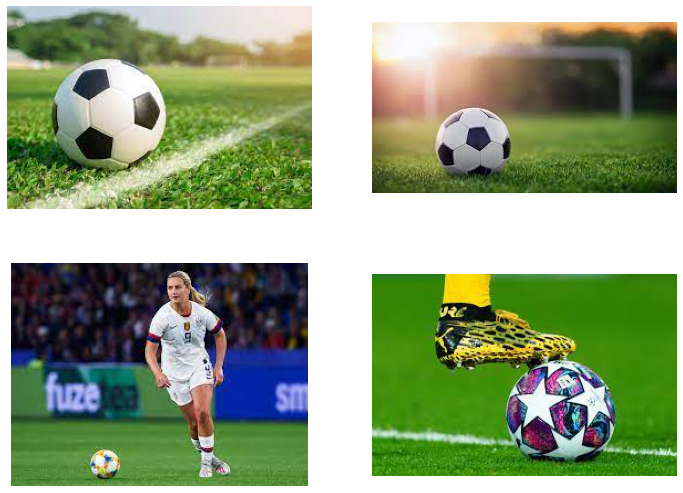

In [ ]:
from PIL import Image
from ball_detection.utils import plot_images
import glob
from tqdm import tqdm

im_paths = glob.glob('./data/samples/**.jpeg', recursive=True)
images = [Image.open(path) for path in im_paths]

plot_images(images[:4])

## Hough Circle Transfrorm

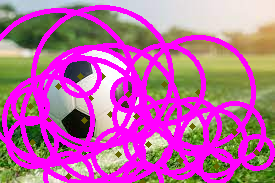

In [ ]:
import sys
import cv2 as cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ball_detection.utils import pil2cv, cv2pil
from IPython.display import display

filename = im_paths[0]
# Loads an image
src = cv.imread(cv.samples.findFile(filename), cv.IMREAD_COLOR)
# Check if image is loaded fine
if src is None:
    print ('Error opening image!')
    print ('Usage: hough_circle.py [image_name -- default ' + default_file + '] \n')

gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)

rows = gray.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, rows / 8,
                           param1=100, param2=30,
                           minRadius=1, maxRadius=100)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(src, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv.circle(src, center, radius, (255, 0, 255), 3)
cv2pil(src)

## YOLO

In [ ]:
x1

38.970706939697266

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 606 layers, 141755500 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-7-5 torch 1.8.1+cu102 CUDA:0 (GeForce GTX 1080 Ti, 11178.5MB)



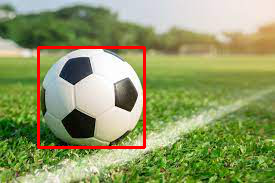

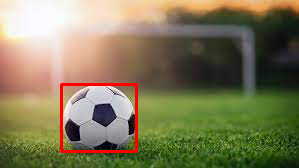

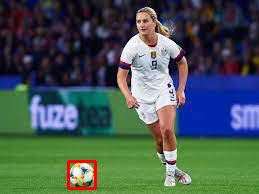

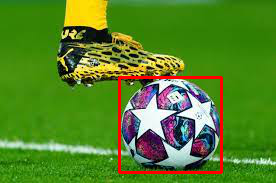

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')  #  P6 model

bboxes = []
for img in images:
    results = model(img, size=img.width, augment=True)
    row = results.pandas().xyxy[0]
    x1,y1,x2,y2 = row[row['name']=='sports ball'][['xmin','ymin','xmax','ymax']].values[0].astype(int)
    bboxes.append([x1,y1,x2,y2])
    imc = img.copy()
    
    imc = cv2.rectangle(pil2cv(imc), (x1,y1), (x2,y2), (0,0,255), 2)
    display(cv2pil(imc))

## Seperability Filter

18 18 13


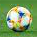

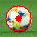

In [ ]:
idx = 2

im = images[idx]
x1,y1,x2,y2 = bboxes[idx]
mx = int((x2 - x1) * 0.2)
my = int((y2 - y1) * 0.2)
im = pil2cv(im)[max(0, y1-my):y2+my, max(0, x1-mx):x2+mx]

cx = (x2 - x1) // 2 + mx
cy = (y2 - y1) // 2 + my
r = ((x2 - x1) + (y2 - y1)) // 4 
print(cx, cy, r)

im_circle = im.copy()
im_circle = cv.circle(im_circle, (cx, cy), 0, (0,0,255), thickness=5)
im_circle = cv.circle(im_circle, (cx, cy), r, (0,0,255), thickness=1)

display(cv2pil(im))
display(cv2pil(im_circle))

In [ ]:
def intensity_region_1(img, cx, cy, r, return_pixels=False):
    width = img.shape[0]
    height = img.shape[1]
    mask = np.zeros((width, height), np.uint8)

    circle_img = cv.circle(mask,(cx,cy),r, (255,255,255), thickness=-1)
    masked_data = cv.bitwise_and(img, img, mask=circle_img)
    
    pixels = masked_data[masked_data!=0]
    n_pixels =  len(pixels)
    mean_intensity = np.sum(np.max(masked_data, axis=-1)) / n_pixels
    
    
    if return_pixels:
        return pixels 
    return mean_intensity, n_pixels 
    
def intensity_region_2(img, cx, cy, r_in, r_out):
    assert r_in < r_out
    width = img.shape[0]
    height = img.shape[1]
    mask_r_out, mask_r_in = np.zeros((width, height), np.uint8), np.zeros((width, height), np.uint8)

    mask_r_out = cv.circle(mask_r_out,(cx,cy),r_out, (255,255,255), thickness=-1)
    mask_r_in = cv.circle(mask_r_in,(cx,cy),r_in, (255,255,255), thickness=-1)
    mask = cv.bitwise_and(mask_r_out, mask_r_out, mask=cv.bitwise_not(mask_r_in))
    
    masked_data = cv.bitwise_and(img, img, mask=mask)
    
    pixels = masked_data[masked_data!=0]
    n_pixels =  len(pixels)
    mean_intensity = np.sum(np.max(masked_data, axis=-1)) / n_pixels
    return mean_intensity, n_pixels


# print(intensity_region_1(im, cx, cy, r))
# print(intensity_region_2(src, 200, 300, 40, 100))
# print(intensity_region_1(im, cx, cy, r, return_pixels=True))

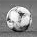

In [ ]:
def seperability_filter(img, r_in, r_out):
    width, height = img.shape[:2]
    result = np.zeros((width, height))
    
    for x in tqdm(range(r_out, width-r_out)):
        for y in range(r_out, height-r_out):
            I_in, n_in = intensity_region_1(img, x, y, r_in)
            I_out, n_out = intensity_region_2(img, x, y, r_in, r_out) 
            
            n_all = n_in + n_out
            I_all = (n_in * I_in + n_out * I_out) / n_all
            
            pixels = intensity_region_1(img, x, y, r_out, True)
            mean_sum = sum([np.square(px - I_all) for px in pixels])
            eta_dash = n_in * np.square((I_in - I_all)) + n_out * np.square((I_out - I_all)) / mean_sum
            
            if I_in >= I_out:
                eta = eta_dash
            else:
                eta = -eta_dash 
            
            result[x, y] = abs(eta)
    return result

# im_gray = pil2cv(cv2pil(im).resize((50,50))).copy()
im_gray = pil2cv(cv2pil(im)).copy()
im_gray = cv2.cvtColor(im_gray, cv2.COLOR_BGR2GRAY)
display(cv2pil(im_gray))

# results = []
# for r_in in tqdm(range(int(r*0.9), int(r*1.2))[::5]):
#     for r_out in range(r_in + 1, int(r*1.2))[::4]:
#         result = seperability_filter(im, r_in, r_out)
#         results.append(result)

# resmax = np.zeros(result.shape)
# for res in results:
#     resmax = np.maximum(res, resmax)

# print(resmax.max())
# plt.imshow(resmax)
# plt.show()

100%|██████████| 1/1 [00:00<00:00, 153.34it/s]

460.2558225583778
18 18


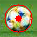

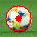

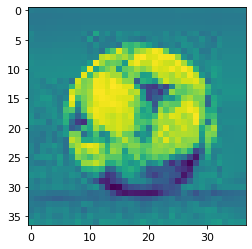

In [ ]:
r_in = 14
r_out = 18
sep = seperability_filter(im_gray, r_in, r_out)
print(sep.max())

plt.imshow(sep)
plt.show()
plt.imshow(im_gray)
plt.show()

cx_refine, cy_refine = np.unravel_index(sep.argmax(), sep.shape) 

print(cx_refine, cy_refine)

r = r_in
im_circle_refine = im.copy()
im_circle_refine = cv.circle(im_circle_refine, (cx_refine, cy_refine), 0, (0,0,255), thickness=5)
im_circle_refine = cv.circle(im_circle_refine, (cx_refine, cy_refine), r, (0,0,255), thickness=1)

display(cv2pil(im_circle_refine))
display(cv2pil(im_circle))

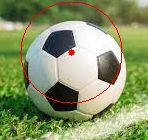

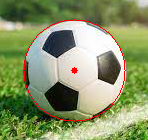

In [ ]:
cx_refine, cy_refine = np.unravel_index(resmax.argmax(), result.shape) 

cx_refine -= mx//2
cy_refine -= my//2

im_circle_refine = im.copy()
im_circle_refine = cv.circle(im_circle_refine, (cx_refine, cy_refine), 0, (0,0,255), thickness=5)
im_circle_refine = cv.circle(im_circle_refine, (cx_refine, cy_refine), r, (0,0,255), thickness=1)

display(cv2pil(im_circle_refine))
display(cv2pil(im_circle))

In [ ]:
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms import ToTensor, Compose, ToPILImage, Normalize
from ball_detection.dataset import XMLDetectionDataModule, XMLDetectionDataset
from ball_detection.cnn_module import *
from torchvision.models.detection import fasterrcnn_resnet50_fpn
# Setup a model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model = TorchVisionDetector(model)

# Prepare data
data_dir = './data/data/train'
image_transform = Compose([
    ToTensor(),
    lambda x: x.unsqueeze(0)])

dataset = XMLDetectionDataset(root=data_dir, image_transform=image_transform, target_transform=None, transform=None)

AssertionError: (236, 234)

In [ ]:
# Inference with XMLDetectionDataset

img, label = dataset[0]
model.eval()

pred = model(img)
bbox = pred[0]['boxes'][0].detach().numpy()
iou = bbox_iou(label, bbox)

print('label:', label)
print('bbox:', bbox)
print('IoU:', iou)

NameError: name 'dataset' is not defined

In [ ]:
visualize(
    img.detach().numpy()[0].transpose(1,2,0),
    [bbox.astype(int), label],
    [0, 1],
    {0:'bboxA', 1:'bboxB'},
)